In [22]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [23]:
tickers = ['SPY', 'QQQ', 'BND', 'GLD', 'VTI']
end_date = datetime.now()
start_date = end_date - timedelta(days=365*10)
adj_close = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    adj_close[ticker] = data['Adj Close']
adj_close

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,SPY,QQQ,BND,GLD,VTI
Date,,,,,
2014-08-29,167.997009,92.056786,62.882965,123.860001,87.143166
2014-09-02,167.913330,92.324341,62.668571,121.650002,87.210266
2014-09-03,167.821259,91.780006,62.775398,122.150002,87.118011
2014-09-04,167.578491,91.696976,62.668571,121.480003,86.933449
2014-09-05,168.331833,92.158279,62.645660,122.059998,87.336090
...,...,...,...,...,...
2024-08-19,559.609985,481.269989,74.339996,231.610001,275.750000
2024-08-20,558.700012,480.260010,74.559998,232.460007,275.079987
2024-08-21,560.619995,482.500000,74.720001,232.149994,276.459991


#### Lognormal Returns

In [24]:
log_returns = np.log(adj_close / adj_close.shift(1))
log_returns = log_returns.dropna()
log_returns

,SPY,QQQ,BND,GLD,VTI
Date,,,,,
2014-09-02,-0.000498,0.002902,-0.003415,-0.018004,0.000770
2014-09-03,-0.000548,-0.005913,0.001703,0.004102,-0.001058
2014-09-04,-0.001448,-0.000905,-0.001703,-0.005500,-0.002121
2014-09-05,0.004485,0.005018,-0.000366,0.004763,0.004621
2014-09-08,-0.002589,0.001900,-0.000731,-0.010956,-0.002019
...,...,...,...,...,...
2024-08-19,0.009516,0.013050,0.001211,-0.001639,0.009400
2024-08-20,-0.001627,-0.002101,0.002955,0.003663,-0.002433
2024-08-21,0.003431,0.004653,0.002144,-0.001335,0.005004


#### Covariance Matrix

In [25]:
# 252 trading days in a year
cov_matrix = log_returns.cov()*252
cov_matrix

,SPY,QQQ,BND,GLD,VTI
SPY,0.031311,0.035868,0.001006,0.000962,0.031829
QQQ,0.035868,0.047566,0.001329,0.001452,0.036410
BND,0.001006,0.001329,0.002924,0.002791,0.001094
GLD,0.000962,0.001452,0.002791,0.020263,0.001084
VTI,0.031829,0.036410,0.001094,0.001084,0.032623


In [26]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [27]:
# expected returns assuming they are based on historical returns
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

In [28]:
# calulating sharpe ratio
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    ret = expected_return(weights, log_returns)
    std = standard_deviation(weights, cov_matrix)
    return (ret - risk_free_rate) / std

In [29]:
risk_free_rate = 0.034

In [30]:
# in case of scipy.optimize.minimize, there is no direct method to find the maximum value of a function
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [31]:
# in my case, the constraint is that the sum of all portfolio weights should be 1. 
# bounds are limits placed on portfolio weights and each weight should be between 0 and 1
# 0 =>  we can't go short on any asset
# 0.5 => we can't allocate more than 50% of the portfolio to any asset
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = [(0, 0.5) for i in range(len(tickers))]    # 0 <= weight <= 0.5

In [32]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
initial_weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [33]:
optimised_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', bounds=bounds, constraints=constraints)

In [34]:
optimisal_weights = optimised_results.x

In [35]:
for ticker, weight in zip(tickers, optimisal_weights):
    print(f'{ticker}: {weight:.4f}%')
optimal_portfolio_return = expected_return(optimisal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimisal_weights, cov_matrix)
optimal_sharpr_ratio = sharpe_ratio(optimisal_weights, log_returns, cov_matrix, risk_free_rate)
print(f'Expected return: {optimal_portfolio_return:.4f}')
print(f'Volatility: {optimal_portfolio_volatility:.4f}')
print(f'Sharpe ratio: {optimal_sharpr_ratio:.4f}')

SPY: 0.1189%
QQQ: 0.5000%
BND: 0.0000%
GLD: 0.3811%
VTI: 0.0000%
Expected return: 0.1212
Volatility: 0.1421
Sharpe ratio: 0.6141


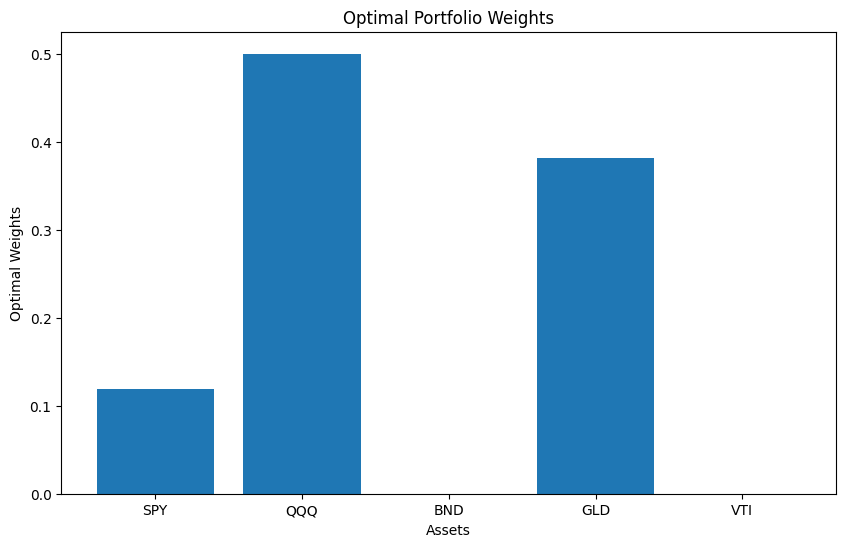

In [36]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimisal_weights)

plt.title('Optimal Portfolio Weights')
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')

plt.show()